In [1]:
init = False

In [2]:
if (init):
    !pip install gdown

In [3]:
# https://drive.google.com/file/d/1E64A5nPZoW07BtX4DpI7uRNn8ABZPytF/view?usp=sharing
if (init):
    import gdown
    raw_url = 'https://drive.google.com/file/d/1-C5YuxA0BHVkB7HPMSN6tlJpbO3ksZxI/view?usp=sharing'
    id = '1-C5YuxA0BHVkB7HPMSN6tlJpbO3ksZxI'
    url = f'https://drive.google.com/uc?id={id}'
    output = 'working.zip'
    gdown.download(url, output, quiet = False)

In [4]:
if (init):
    !mv -f /kaggle/working/working.zip /kaggle/
    !ls -a
    !unzip /kaggle/working.zip -d /kaggle/

# init params

In [5]:
from argparse import Namespace


# model_name = 'tf_efficientnet_b4.ns_jft_in1k'
model_name='resnet50_gn.a1h_in1k'
args = Namespace(
  num_classes=200,
  in_channels=3,
  mid_channels=128,
  z_dim=128,
  num_ae_layers=0,
  num_protos = 600,
  freeze_body=True,
  # unfreeze_steps=[(10, '.')],
  unfreeze_steps_pretrained=[(0, '7.'), (2000, '.')],
  # unfreeze_steps=[(0, '.')],
  # unfreeze_steps=[(1000, '7.2'), (5000, '7.1'), (10000, '7.'), (15000, '.')],

  unfreeze_steps=[(1000, '7.2'), (4000, '7.1'), (9000, '7.')],
  batchsize=20,
  num_steps=10000,

  bias=False,

  kappa = 10,
  sharpen_pow = 2,
  bn_momentum = 1e-2,
  backbone_bn_momentum = 1e-2,

  model_name=model_name,

  # mask_threshold=0.1,
  # backbone_coef=1.0,
  last_layer_coef=1.0,
  # rec_coef=0.0,
  clus_coef=1.0,
  # unif_weight=0.1,
  # align_weight=1.0,
  contrastive_weight = 1.0,
  protos_probs_weight=0.5,
  # protos_sim_weight=0.1,
  l1_coef = 1.,


  prune_threshold=0.9,
  first_prune = 500,
  prune_every = 200,

  # lr=1e-4,
  lr_features=2.5e-05,
  lr_prototype_vectors=5e-04,
  lr_last_layers=2.5e-03,

  device='cuda',
  warmup_steps=20,
  val_batchsize=64,
  grad_accumulation_steps=4,
  num_steps_pretrained=10,
  num_epochs=200,
  checkpointing_steps=500,
  save_path=f'../working/protopnet_v1/cub2002011/resnet50_gn.a1h_in1k/'
)

In [6]:
import random
import os
import numpy as np
import torch
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(18022004)

# init dataset

In [7]:
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset


class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target


class ContrastiveDataset(Dataset):
  def __init__(self, root, transform1, transform2):
    self.dataset = Cub2011(root, True, None)
    self.transform1 = transform1
    self.transform2 = transform2


  def __getitem__(self, idx):
    img, target = self.dataset.__getitem__(idx)

    img = self.transform1(img)
    return self.transform2(img), self.transform2(img), target

  def __len__(self):
    return len(self.dataset)

# init transforms

In [8]:
import numpy as np
import argparse
import torch
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from typing import Tuple, Dict
from torch import Tensor
import random


IMAGE_SIZE = 288
# IMAGE_SIZE = 224

# function copied from https://pytorch.org/vision/stable/_modules/torchvision/transforms/autoaugment.html#TrivialAugmentWide (v0.12) and adapted
class TrivialAugmentWideNoColor(transforms.TrivialAugmentWide):
    def _augmentation_space(self, num_bins: int) -> Dict[str, Tuple[Tensor, bool]]:
        return {
            "Identity": (torch.tensor(0.0), False),
            "ShearX": (torch.linspace(0.0, 0.5, num_bins), True),
            "ShearY": (torch.linspace(0.0, 0.5, num_bins), True),
            "TranslateX": (torch.linspace(0.0, 16.0, num_bins), True),
            "TranslateY": (torch.linspace(0.0, 16.0, num_bins), True),
            "Rotate": (torch.linspace(0.0, 60.0, num_bins), True),
        }


import random

from PIL import ImageFilter

class GaussianBlur:
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


class TrivialAugmentWideNoShape(transforms.TrivialAugmentWide):
    def _augmentation_space(self, num_bins: int) -> Dict[str, Tuple[Tensor, bool]]:
        return {

            "Identity": (torch.tensor(0.0), False),
            "Brightness": (torch.linspace(0.0, 0.5, num_bins), True),
            "Color": (torch.linspace(0.0, 0.02, num_bins), True),
            "Contrast": (torch.linspace(0.0, 0.5, num_bins), True),
            "Sharpness": (torch.linspace(0.0, 0.5, num_bins), True),
            "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 6)).round().int(), False),
            "AutoContrast": (torch.tensor(0.0), False),
            "Equalize": (torch.tensor(0.0), False),
        }


shape = (3, IMAGE_SIZE, IMAGE_SIZE)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
normalize = transforms.Normalize(mean=mean,std=std)
transform_no_augment = transforms.Compose([
                        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
                        transforms.ToTensor(),
                        normalize
                    ])
transform1p = None
transform1 = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE+8, IMAGE_SIZE+8)),
    TrivialAugmentWideNoColor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMAGE_SIZE+4, scale=(0.95, 1.))
])
transform1p = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE+32, IMAGE_SIZE+32)), #for pretraining, crop can be bigger since it doesn't matter when bird is not fully visible
    TrivialAugmentWideNoColor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMAGE_SIZE+4, scale=(0.95, 1.))
])
transform2 = transforms.Compose([
                    # TrivialAugmentWideNoShape(),

                    transforms.RandomApply(
                        [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8  # not strengthened
                    ),
                    transforms.RandomGrayscale(p=0.2),
                    transforms.RandomApply([GaussianBlur([0.1, 2.0])], p=0.5),


                    transforms.RandomCrop(size=(IMAGE_SIZE, IMAGE_SIZE)), #includes crop
                    transforms.ToTensor(),
                    normalize
                    ])

test_transform = transform_no_augment


# load dataset

In [9]:
from torch.utils.data import DataLoader

root = '../input/cub2002011'
trainds = ContrastiveDataset(root,
                             transform1=transform1, transform2=transform2)
contrastiveds = ContrastiveDataset(root,
                             transform1=transform1p, transform2=transform2)
valds = Cub2011(root,train=False, transform=test_transform)

train_loader = DataLoader(trainds, shuffle=True, batch_size=args.batchsize, drop_last=True)
contrastive_loader = DataLoader(contrastiveds, shuffle=True, batch_size=args.batchsize, drop_last=True)
val_loader = DataLoader(valds, batch_size=args.val_batchsize)

# init model

In [10]:
from timm import create_model
from fastai.vision.learner import _update_first_layer, has_pool_type, create_head, num_features_model
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models.resnet import BasicBlock
from timm.layers.norm_act import BatchNormAct2d


def set_track_running_stats(module, track=True):
  if type(module).__name__.__contains__('BatchNorm'):
      module.track_running_stats = track
  for child in module.children():
    set_track_running_stats(child, track)


def set_bn_momentum(module, momentum=0.01):
  if type(module).__name__.__contains__('BatchNorm'):
      module.momentum = momentum
  for child in module.children():
    set_bn_momentum(child, momentum)


def set_training(module, train=True):
  module.train(train)
  set_track_running_stats(module, train)


def freeze_body(model, model_name='resnet50', params_to_train=None):
  if params_to_train is not None:
    for name,param in model.named_parameters():
      if any((param_name in name) for param_name in params_to_train):
        param.requires_grad=True
      else:
        param.requires_grad=False
    return
  if 'resnet50' in model_name:
    freeze_body(model, model_name, params_to_train=['7.0', '7.1', '7.2'])


def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NameError("cut must be either integer or function")


# adapted from https://github.com/yumeng5/TopClus/blob/main/src/trainer.py
def target_distribution(probs, p=2):
    targets = (probs ** p) / probs.sum(dim=1, keepdim=True)  # shape: (B, N, K)
    targets = (targets / targets.sum(dim=2, keepdim=True))
    return targets



# adapted from https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear
class NonNegLinear(nn.Module):
    """Applies a linear transformation to the incoming data with non-negative weights`
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(NonNegLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(1e-1 * torch.randn((out_features, in_features), **factory_kwargs))
        self.normalization_multiplier = nn.Parameter(torch.ones((1,),requires_grad=True))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input,torch.relu(self.weight), self.bias)

class MyModel(nn.Module):
  def __init__(self, args):
    super(MyModel, self).__init__()

    self.args = args

    self.z_dim = args.z_dim
    mid_channels = args.mid_channels
    self.kappa = args.kappa
    self.num_protos = args.num_protos

    self.backbone = create_timm_body(args.model_name, pretrained=True, n_in=args.in_channels)

    self.nf = num_features_model(self.backbone)

    norm_layer = nn.Identity
    num_ae_layers = args.num_ae_layers
    self.z_encoder = nn.Sequential(
      nn.Conv2d(self.nf       , self.z_dim * 1, kernel_size=1, stride=1, padding=0),
    )
    # self.z_decoder = nn.Sequential(
    #   nn.Conv2d(self.z_dim * 1, self.nf       , kernel_size=1, stride=1, padding=0),
    # )


    self.pool_layer = nn.Sequential(
      nn.AdaptiveMaxPool2d(output_size=(1,1)), #outputs (bs, ps,1,1)
      nn.Flatten() #outputs (bs, ps)
    )

    self.prototype_vectors = nn.Parameter(torch.rand(self.num_protos, self.z_dim), requires_grad=True)

    # self.classification_head = create_head(self.nf, args.num_classes, pool=False)
    self.protos_classifier = NonNegLinear(self.num_protos, args.num_classes, bias=args.bias)
    self.protos_mask = nn.Parameter(torch.ones(self.num_protos), requires_grad=False)


    # get cosine to the protos (centroid of each cluster)
  def get_protos_sim(self, z, mask_value=-1.0):
    # project the embedding to a smaller latent space, resnet default embedding is 2048, too big, curse of dimensionality
    # z.shape = (b, z_dim, h1, w1)
    z = F.normalize(z, dim=1)
    self.prototype_vectors.data = F.normalize(self.prototype_vectors.data, dim=1)
      # sim.shape (b, protos_num, h1, w1)
    sim = torch.einsum('bdhw,dk->bkhw', z, self.prototype_vectors.t())
      # protos_mask.shape = (1, protos_num, 1, 1)
    protos_mask = self.protos_mask.view(1, self.num_protos, 1, 1).expand_as(sim)
    return sim.where(protos_mask == 1.0, mask_value)

  def get_protos_probs(self, z):
    sim = self.get_protos_sim(z)
    probs = F.softmax(sim * self.kappa, dim=1)
    return probs

  def get_protos_probs_patches(self, x):
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    h_patches = self.backbone(x)
    z_patches = self.z_encoder(h_patches)

    protos_probs_patches = self.get_protos_probs(z_patches) # (b, num_protos, h, w)
    return protos_probs_patches

  def get_protos_probs_images(self, x):
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    h_patches = self.backbone(x)
    h_image = h_patches.mean(dim=[2, 3]) # (b, nf)
    z_image = self.z_encoder(h_image.view(b, nf, 1, 1)) # (b, z_dim, 1, 1)
    protos_probs = self.get_protos_probs(z_image).view(b, -1) # (b, num_protos)
    return protos_probs


  def get_protos_sim_patches(self, x):
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    h_patches = self.backbone(x)
    z_patches = self.z_encoder(h_patches)

    protos_sim_patches = self.get_protos_sim(z_patches) # (b, num_protos, h, w)
    return protos_sim_patches

  def get_protos_sim_images(self, x):
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    h_patches = self.backbone(x)
    h_image = h_patches.mean(dim=[2, 3]) # (b, nf)
    z_image = self.z_encoder(h_image.view(b, nf, 1, 1)) # (b, z_dim, 1, 1)
    protos_sim_images = self.get_protos_sim(z_image).view(b, -1) # (b, num_protos)
    return protos_sim_images


  def fix_linear_weights(self):
    pass

  def prune_protos(self, threshold=0.0):
    pass


  def forward(self, x, lbl=None, calc_contrastive_loss=False, calc_classification_loss=False,):
    if len(x.shape) == 3: x = x[None]
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    # embedding of the input
    h_patches = self.backbone(x)

    # project the embedding to a smaller latent space, resnet default embedding is 2048, too big, curse of dimensionality
    # z.shape = (b, z_dim, h1, w1)
    z_patches = self.z_encoder(h_patches)


    # debug_val =(z_patches.detach().max()).item()
    # if debug_val > 500:
    #   print('warning, weights are too big', debug_val)

    # protos_sim_patches.shape = (b, protos_num, h1, w1)
    protos_sim_patches = self.get_protos_sim(z_patches)
    protos_probs_patches = F.softmax(protos_sim_patches * self.kappa, dim=1)

    protos_sim = self.pool_layer(protos_sim_patches)
    # protos_mask = self.protos_mask.view(1, self.num_protos).expand_as(protos_sim)
    # protos_sim = protos_sim.where(protos_mask == 1.0, -1.0)

    logits = None

    inference = (not calc_contrastive_loss) and (not calc_classification_loss)
    if inference:
      logits = self.protos_classifier(F.relu(protos_sim))
      return logits

    if calc_classification_loss:
      logits = self.protos_classifier(F.relu(protos_sim))
      classification_loss = (
        self.args.last_layer_coef * (
          F.cross_entropy(logits, lbl)
        )
      )
      ret_classification_loss = (
        classification_loss.detach() / self.args.last_layer_coef
      )

      linear_weights = torch.cat([F.relu(x).view(-1) for x in [self.protos_classifier.weight]])
      l1_reg = self.args.l1_coef * torch.norm(linear_weights, 1) / linear_weights.shape[0]
    else:
      classification_loss = torch.tensor(0.0, device=x.device)
      ret_classification_loss = torch.tensor(0.0, device=x.device)
      l1_reg = torch.tensor(0.0, device=x.device)


    if calc_contrastive_loss:
      clus_weight = args.clus_coef
      ### NT_Xent loss
      temperature = 1.
      # [B, D, H, W]
        # divide by B, shape = (B // 2, D, H, W)
        # we concat the contrastive pair above, now we neeed to split
      z_patches1, z_patches2 = z_patches.chunk(2)
      out_1 = F.normalize(z_patches1,dim=1).flatten(start_dim=2).permute(0,2,1).flatten(end_dim=1)
      out_2 = F.normalize(z_patches2,dim=1).flatten(start_dim=2).permute(0,2,1).flatten(end_dim=1)
      curr_b = out_1.shape[0]
      # [2*B, D]
      out = torch.cat([out_1, out_2], dim=0)
      # [2*B, 2*B]
        # build the sim matrix with every other samples (a patch) in the batch
      sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
        # remove the diagonal
      mask = (torch.ones_like(sim_matrix) - torch.eye(2 * curr_b, device=sim_matrix.device)).bool()
      # [2*B, 2*B-1]
      sim_matrix = sim_matrix.masked_select(mask).view(2 * curr_b, -1)

      # compute loss of patches
        # cosine sim
      pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
      # [2*B]
      pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
      contrastive_loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()

      ### sharpen the prototypes distribution
        # calculate the probs of protos
      protos_probs_weight = self.args.protos_probs_weight
      contrastive_weight = self.args.contrastive_weight
      b, k, h, w = protos_probs_patches.shape
      preds = protos_probs_patches.view(b, k, -1).transpose(1, 2) + 1e-6 # (b, h*w, k)
      preds /= preds.sum(dim=2, keepdim=True)
      targets = target_distribution(preds.detach(), self.args.sharpen_pow).detach()
      # if ((targets - preds).sum().item() == 0.0):
      #   print(F.cross_entropy(preds.log(), targets).item(), targets)
      # protos_probs_loss = F.kl_div(preds.log().reshape(-1, k), targets.reshape(-1, k), reduction='batchmean')
      protos_probs_loss = F.cross_entropy(preds.log().reshape(-1, k), targets.reshape(-1, k).detach())
      clustering_loss = clus_weight * (contrastive_weight * contrastive_loss + protos_probs_weight * protos_probs_loss)


      # contrastive_loss = torch.tensor(0.0, device=x.device)
      # protos_probs_loss = torch.tensor(0.0, device=x.device)
      # clustering_loss = torch.tensor(0.0, device=x.device)
    else:
      contrastive_loss = torch.tensor(0.0, device=x.device)
      protos_probs_loss = torch.tensor(0.0, device=x.device)
      clustering_loss = torch.tensor(0.0, device=x.device)


    # Total loss
    total_loss = classification_loss + clustering_loss + l1_reg

    if torch.isnan(total_loss):
      print((classification_loss, (classification_loss, contrastive_loss, protos_probs_loss), l1_reg))
      assert False

    return logits, (total_loss, ret_classification_loss, contrastive_loss, protos_probs_loss, l1_reg)

def uniform_loss(x, t=2):
    # print("sum elements: ", torch.sum(torch.pow(x,2), dim=1).shape, torch.sum(torch.pow(x,2), dim=1)) #--> should be ones
    loss = (torch.pdist(x, p=2).pow(2).mul(-t).exp().mean() + 1e-10).log()
    return loss

# adapted from https://gitlab.com/mipl/carl/-/blob/main/losses.py
def align_loss(inputs, targets, alpha=2, EPS=1e-12):
    assert inputs.shape == targets.shape
    assert targets.requires_grad == False

    loss = (inputs - targets).norm(p=2, dim=1).pow(alpha).mean()
    return loss

def NT_Xent(xs, temperature=1.,):
  batch_size = args.batchsize

  # xs [2*B, D]
  x1, x2 = xs[:batch_size], xs[batch_size:]
  # [2*B, 2*B]
  sim_matrix = torch.exp(torch.mm(xs, xs.t().contiguous()) / temperature)
  mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
  # [2*B, 2*B-1]
  sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

  # compute loss
  pos_sim = torch.exp(torch.sum(x1 * x2, dim=-1) / temperature)
  # [2*B]
  pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
  loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()

  return loss

/drive2/phatnt/ml_testing/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
model = MyModel(args)

In [12]:
set_bn_momentum(model, args.bn_momentum)
set_bn_momentum(model.backbone, args.backbone_bn_momentum)

In [13]:
import numpy as np
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total  = sum(p.numel() for p in model.parameters())
  trainable  = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total, trainable

total, trainable = pytorch_count_params(model.backbone)
print(f"Total: {total/1e6:.4f}M, Trainable: {trainable/1e6:.4f}M")
def get_model_size(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    model_size = sum([np.prod(p.size()) for p in model_parameters])
    return "{}M".format(round(model_size / 1e+3) / 1e3)

get_model_size(model.backbone), get_model_size(model.z_encoder), get_model_size(model.protos_classifier)

Total: 23.5080M, Trainable: 23.5080M


('23.508M', '0.262M', '0.12M')

In [14]:
from torch.optim import AdamW, SGD
# from lion_pytorch import Lion
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

features = [model.backbone]
add_on_layers = [model.z_encoder]
last_layers = [model.protos_classifier]
sqrt_batchsize = args.batchsize ** 0.5
params = [
  *[{'params': module.parameters(), 'lr': args.lr_features      * sqrt_batchsize, 'weight_decay': 1e-2} for module in features],
  *[{'params': module.parameters(), 'lr': args.lr_features * 10 * sqrt_batchsize, 'weight_decay': 1e-2} for module in add_on_layers],
  *[{'params': module.parameters(), 'lr': args.lr_last_layers   * sqrt_batchsize, 'weight_decay': 1e-2} for module in last_layers],
  *[{'params': model.prototype_vectors, 'lr': args.lr_prototype_vectors * sqrt_batchsize, 'weight_decay': 1e-2}],
]

# opt = Lion(params)
opt = AdamW(params)
# opt = SGD(params)

num_steps = min(args.num_epochs * len(train_loader), args.num_steps)
warmup = LinearLR(opt, start_factor=1/args.warmup_steps, total_iters=args.warmup_steps)
reduce = CosineAnnealingLR(opt, T_max=num_steps)
scheduler = SequentialLR(opt, [warmup, reduce], milestones=[args.warmup_steps])

In [15]:
import torch
import os


def save_model(step, best_score):
  # save_dir = os.path.join(args.save_path, 'ckpt%d'%step)
  os.makedirs(args.save_path, exist_ok=True)
  # torch.save((best_score, model.state_dict()), os.path.join(save_dir, 'pytorch_model.bin'))
  torch.save((best_score, model.state_dict()), os.path.join(args.save_path, 'pytorch_model.bin'))

def load_model(prev_score):
  if os.path.isfile(os.path.join(args.save_path, 'pytorch_model.bin')):
    best_score, state_dict = torch.load(os.path.join(args.save_path, 'pytorch_model.bin'))
    if best_score > prev_score:
      model.load_state_dict(state_dict)
      print('loaded')
      prev_score = best_score
  return prev_score

In [16]:
from sklearn.metrics import top_k_accuracy_score
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def eval():
  pbar = tqdm(val_loader, position=0, leave=True)
  model.to(args.device)
  set_training(model, False)
  y_pred = []
  y_true = []
  with torch.no_grad():
    for sample in pbar:
      image, label = sample
      image = image.to(args.device)
      label = label.to(args.device)
      out, all_losses = model.forward(image, label, calc_classification_loss=True)
      out = F.softmax(out, dim=1)

      y_pred += [out.detach().cpu().numpy()]
      y_true += [label.cpu().numpy()]
      pbar.set_description('acc=%.4f' % (
        top_k_accuracy_score(np.concatenate(y_true, axis=0), np.concatenate(y_pred, axis=0), k=1, labels=range(args.num_classes)),
      ))

  y_true = np.concatenate(y_true, axis=0)
  y_pred = np.concatenate(y_pred, axis=0)
  return (top_k_accuracy_score(y_true, y_pred, k=1, labels=range(args.num_classes)),
        top_k_accuracy_score(y_true, y_pred, k=5, labels=range(args.num_classes)))


# init train

In [17]:
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [18]:
set_training(model, False)
model.cuda()
xs1, xs2, ys = next(iter(train_loader))
xs, ys = torch.cat([xs1,xs2]), torch.cat([ys,ys])
x = xs.cuda()
y = ys.cuda()
with torch.no_grad():
  logits, losses = model(x, y, True, True)
[l.item() for l in losses]

[16.166181564331055,
 5.40908145904541,
 7.647158622741699,
 6.140552997589111,
 0.03966611251235008]

# infer

In [19]:
best_score = load_model(0.0)
print('best_score =',best_score)
# for _ in range(10):
#   model.prune_protos(0.9)

/tmp/ipykernel_3674617/54921099.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_score, state_dict = torch.load(os.path.join(args.save_path, 'pytorch_model.bin'))


loaded
best_score = 0.7709699689333793


In [20]:
val_dataset = list(iter(val_loader))

In [21]:
len(val_dataset)

91

In [22]:
with open('../input/cub2002011/CUB_200_2011/classes.txt', 'r') as classes_file:
    labels = {
        int(s.strip().split(' ')[0]): s.strip().split(' ')[1]
        for s in classes_file
    }

In [23]:
val_ids = list(range(len(val_dataset)))
# import random
# random.shuffle(val_ids)

inferred = {}

model.eval().cuda()

with torch.no_grad():
    for idx in tqdm(range(len(val_dataset))):
        x, y = val_dataset[idx]
        # x, y = x[:1], y[:1]
        out = model(x.cuda(), None, False, False)

        inferred[idx] = {
            'x': x.cpu(),
            'y': y.cpu(),
            'out': out.cpu(),
        }

  0%|          | 0/91 [00:00<?, ?it/s]

100%|██████████| 91/91 [00:14<00:00,  6.34it/s]


In [24]:
rights = []
wrongs = []

for idx in inferred:
    output = inferred[idx]
    x = output['x']
    y = output['y']
    out = output['out']

    y_pred = torch.zeros(len(out))
    for i in range(len(out)):
        y_pred[i] = out[i].argmax()

    for i in range(len(out)):
        if (y[i] != y_pred[i]):
            wrongs.append(
                {
                    'x': x[i : i + 1],
                    'y': y[i : i + 1],
                    'out': out[i : i + 1],
                    'y_pred': y_pred[i : i + 1],
                }
            )
        else:
            rights.append(
                {
                    'x': x[i : i + 1],
                    'y': y[i : i + 1],
                    'out': out[i : i + 1],
                    'y_pred': y_pred[i : i + 1],
                }
            )

len(rights), len(wrongs)

(4467, 1327)

In [25]:
import torch
from PIL import Image
import torchvision.transforms as transforms

def infer_from_file(file, ground_truth):
    img = Image.open(file)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = transforms.ToTensor()(img)
    if img.shape[0] > 3:
        img = img[:3, :, :]
    img = img[None]
    with torch.no_grad():
        out = model(img.cuda(), None, False, False)

    y = torch.tensor(ground_truth)
    y = y[None]
    y_pred = torch.tensor([1])
    y_pred[0] = out[0].argmax()
    return img, y, out, y_pred

In [26]:
def get_protos_score(x, y, out, pred):
    with torch.no_grad():
        pp = model.get_protos_probs_patches(x=x.cuda())
        ps = model.get_protos_sim_patches(x=x.cuda())
        pset = set()
        for bi in range(len(pp)):
            pset.add(tuple(pid for pid in range(args.num_protos) if pp[bi,pid].max() > 0.5))

        protos_sim = F.max_pool2d(ps, kernel_size=ps.shape[2:]).view(ps.shape[0], -1).cpu() # (b, num_protos)

    logits = out
    log_prob, c_pred = logits[0,].max(dim=0)

    lin_weight = list(model.protos_classifier.parameters())
    len(lin_weight)
    W, b = model.protos_classifier.weight, list(lin_weight)[1]
    W, b = W.detach().cpu(), b.detach().cpu()

    if not args.bias:
        # print((b[0] + torch.sum(W[c_pred, :] * protos_sim[0])), log_prob)

        protos_score = W[c_pred, :] * protos_sim[0]
        sorted_scores, indices = protos_score.sort(descending=True)
        # print(*[f'score={sorted_scores[i].item():.4f}, sim={protos_sim[0, indices[i].item()].item():.4f}, idx={indices[i].item()}' for i in range(10)], sep='\n')

    return pp, ps, protos_score

def viz_kth_best(x, y, out, pred, file_inferred = False, k = 0,):
    pp, ps, protos_score = get_protos_score(x, y, out, pred)

    pv = model.prototype_vectors.detach().cpu()

    def pw_cosine_distance(input_a, input_b):
        normalized_input_a = torch.nn.functional.normalize(input_a)
        normalized_input_b = torch.nn.functional.normalize(input_b)
        res = torch.mm(normalized_input_a, normalized_input_b.T)
        return res

    pw_sim = pw_cosine_distance(pv, pv)

    pmask = model.protos_mask.detach().cpu().numpy()
    for i in range(len(pmask)):
        if pmask[i] < 1e-9:
            pw_sim[i, :] = -1.0
            pw_sim[:, i] = -1.0

    # Sort prototypes by their scores and select top k
    sorted_proto_indices = protos_score.argsort(descending=True)

    import matplotlib.pyplot as plt
    from torchvision import transforms

    # Create a figure with k+1 subplots (original image + k bboxes)
    fig, axes = plt.subplots(1, k+1, figsize=(4*k, 4))

    # Ensure axes is always a list, even if k=1
    if k == 1:
        axes = [axes[0], axes[1]]

    # Remove axis for all subplots
    for ax in axes:
        ax.axis('off')

    # Inverse transformation for image
    invTrans = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
    ])

    # Original image in the last subplot
    if (not file_inferred):
        im = invTrans(x[0].cpu())
    else:
        im = x[0].cpu()
    axes[-1].imshow(np.transpose(im, (1, 2, 0)))
    axes[-1].set_title('Original Image')

    # Render bounding boxes for top k prototypes
    for i in range(k):
        proto_idx = sorted_proto_indices[i].item()

        # Get the mask for this prototype
        mask = pp[0, proto_idx]
        mask = mask / mask.max()

        # Interpolate mask to image size
        mask_inter = F.interpolate(
            mask.view(1, 1, mask.shape[-2], mask.shape[-1]),
            size=x.size()[2:],
            mode='bilinear',
            align_corners=True
        )[0][0]

        mask_inter_np = mask_inter.cpu().numpy()

        # Find the center of the mask
        cy, cx = np.unravel_index(mask_inter_np.argmax(), mask_inter_np.shape)

        # Calculate bounding box
        viz_size = IMAGE_SIZE // (2 * mask.shape[1])
        x_min = int(max(cx - viz_size, 0))
        x_max = int(min(cx + viz_size, IMAGE_SIZE - 1))
        y_min = int(max(cy - viz_size, 0))
        y_max = int(min(cy + viz_size, IMAGE_SIZE - 1))
        bbox = x_min, x_max, y_min, y_max

        # Create a copy of the image with bounding box
        full_im_with_bbox = im.clone().numpy()
        full_im_with_bbox[:, bbox[2]:bbox[3], bbox[0]] = [[0], [1], [0]]
        full_im_with_bbox[:, bbox[2]:bbox[3], bbox[1]] = [[0], [1], [0]]
        full_im_with_bbox[:, bbox[2], bbox[0]:bbox[1]] = [[0], [1], [0]]
        full_im_with_bbox[:, bbox[3], bbox[0]:bbox[1]] = [[0], [1], [0]]

        # Plot the image with bounding box
        axes[i].imshow(np.transpose(full_im_with_bbox, (1, 2, 0)))

        # Add label for the prototype
        proto_score = protos_score[proto_idx].item()
        axes[i].set_title(f'Proto {proto_idx}\nScore: {proto_score:.4f}')

    lbl = y[0].cpu()
    c_pred = pred[0].cpu()
    print('label:', lbl, 'pred:', c_pred)
    print(f'label class: {labels[lbl.item() + 1]}, pred class: {labels[c_pred.item() + 1]}')

    plt.tight_layout()
    plt.show()

def get_from_idx(data, idx):
    x = data[idx]['x'].cpu()
    y = data[idx]['y'].cpu()
    out = data[idx]['out'].cpu()
    y_pred = data[idx]['y_pred'].cpu()

    return x, y, out, y_pred

In [33]:
labels

{1: '001.Black_footed_Albatross',
 2: '002.Laysan_Albatross',
 3: '003.Sooty_Albatross',
 4: '004.Groove_billed_Ani',
 5: '005.Crested_Auklet',
 6: '006.Least_Auklet',
 7: '007.Parakeet_Auklet',
 8: '008.Rhinoceros_Auklet',
 9: '009.Brewer_Blackbird',
 10: '010.Red_winged_Blackbird',
 11: '011.Rusty_Blackbird',
 12: '012.Yellow_headed_Blackbird',
 13: '013.Bobolink',
 14: '014.Indigo_Bunting',
 15: '015.Lazuli_Bunting',
 16: '016.Painted_Bunting',
 17: '017.Cardinal',
 18: '018.Spotted_Catbird',
 19: '019.Gray_Catbird',
 20: '020.Yellow_breasted_Chat',
 21: '021.Eastern_Towhee',
 22: '022.Chuck_will_Widow',
 23: '023.Brandt_Cormorant',
 24: '024.Red_faced_Cormorant',
 25: '025.Pelagic_Cormorant',
 26: '026.Bronzed_Cowbird',
 27: '027.Shiny_Cowbird',
 28: '028.Brown_Creeper',
 29: '029.American_Crow',
 30: '030.Fish_Crow',
 31: '031.Black_billed_Cuckoo',
 32: '032.Mangrove_Cuckoo',
 33: '033.Yellow_billed_Cuckoo',
 34: '034.Gray_crowned_Rosy_Finch',
 35: '035.Purple_Finch',
 36: '036.No

In [28]:
import random
idx, label = random.choice(list(labels.items()))

print(idx - 1, label)

6 007.Parakeet_Auklet


In [64]:
wrong: 105 (Pelagic_Cormorant, Red_faced_Cormorant), 182 (Yellow_billed_Cuckoo, Bohemian_Waxwing)
correct: 192 (Red_winged_Blackbird), 123 (Parakeet_Auklet)

SyntaxError: invalid syntax (1801842114.py, line 1)

label: tensor(9) pred: tensor(9.)
label class: 010.Red_winged_Blackbird, pred class: 010.Red_winged_Blackbird


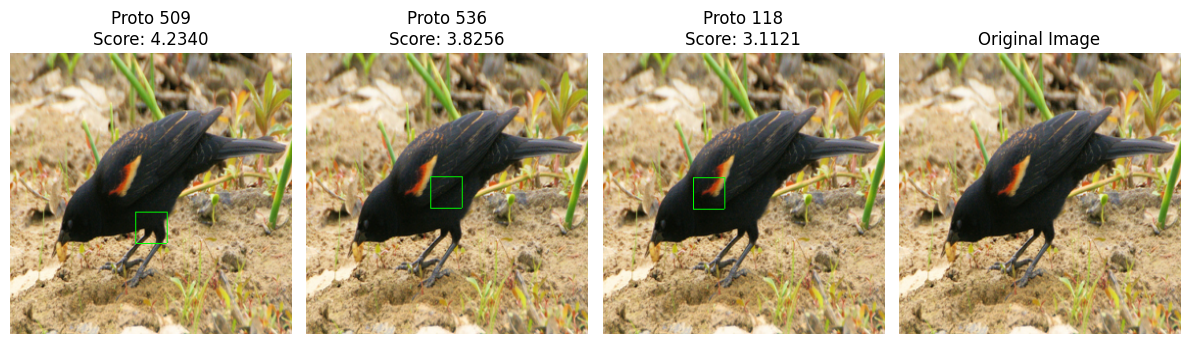

In [73]:
# Example usage
idx = 182
x, y, out, pred = get_from_idx(rights, idx)
# ground_truth 0 indexed
# x, y, out, pred = infer_from_file('../test.png', ground_truth = idx - 1)
viz_kth_best(x, y, out, pred, file_inferred = False, k = 3,) # Visualize top 3 prototypes